Roll: 2019121004 <br>
Name: Avani Gupta

In [1]:
import numpy as np 
import cv2
import glob
import os 
import matplotlib.pyplot as plt
import time

In [2]:
def display_img_arr(img_arr, r, c, dim,titles_arr):
    fl = 0
    fig = plt.figure(figsize = dim)
    for i in range(r):
        for j in range(c):
            if len(img_arr) == fl:
                break
            ax1 = fig.add_subplot(r, c, fl + 1)
            ax1.set_title(titles_arr[fl], fontsize = 20)
            ax1.imshow(img_arr[fl], cmap = 'gray')
            fl = fl + 1
    plt.show()

In [3]:
def calHomography(img1_pt_list, img2_pt_list):

    matx = []
    for i in range(len(img1_pt_list)):
        
        matx.append([*img2_pt_list[i],0,0,0,*(-1*(img2_pt_list[i])*(img1_pt_list[i][0]))])
        matx.append([0, 0, 0, *img2_pt_list[i], *(-1*(img2_pt_list[i]*img1_pt_list[i][1]))])
        
    matx = np.array(matx)  
    u,s,vh = np.linalg.svd(matx) 
    Hmatx = vh.T[:,8].reshape(3,3)
    return Hmatx/Hmatx[2][2]



def calcHomoRansac(homo_img1_pt_list, homo_img2_pt_list, matches, distance, threshold):

    maxInliers = []
    inliers = []
    
    finalH = None
    for i in range(100):
        r4 = np.random.randint(0,len(homo_img2_pt_list),5) 
        img1_pt_list = []
        img2_pt_list = []
        
        for j in r4:
            img1_pt_list.append(homo_img1_pt_list[j])
            img2_pt_list.append(homo_img2_pt_list[j])
            
        Hmatx = calHomography(img1_pt_list, img2_pt_list)
        
        for i in range(len(homo_img1_pt_list)):
            proj = Hmatx@homo_img2_pt_list[i]
            currDist = np.linalg.norm(proj/proj[2] - homo_img1_pt_list[i])
            if currDist < distance:
                inlier = homo_img2_pt_list[i]
                inliers.append(inlier)
                
        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = Hmatx
            
        if len(maxInliers) > len(homo_img1_pt_list)*threshold:
            break
            
    return finalH

def convert_ToHomo(x,X):
    ones = np.ones((len(x),1))
    x = np.concatenate(
        (x,ones),
        axis = 1)
    X = np.concatenate(
        (X,ones),
        axis = 1)
    return x, X

def crop(frame):
  #crop top
    if not np.sum(frame[0]):
        return crop(frame[1:])
  #crop bottom
    if not np.sum(frame[-1]):
        return crop(frame[:-2])
  #crop left
    if not np.sum(frame[:,0]):
        return crop(frame[:,1:])
  #crop right
    if not np.sum(frame[:,-1]):
        return crop(frame[:,:-2])
    return frame


In [4]:
def stichTwoImages(img1,img2):
    matches, kp1 , kp2 , des1 , des2 = match_keypoints(img1,img2) #matches has best matches
    kp1_point_list = []
    kp2_point_list = []
    for m in matches:
        kp1_point_list.append(kp1[m[0].queryIdx].pt)
        kp2_point_list.append(kp2[m[0].trainIdx].pt)
        
    
    homo_kp1_point_list, homo_kp2_point_list  = convert_ToHomo(kp1_point_list, kp2_point_list )
    H = calcHomoRansac(homo_kp1_point_list, homo_kp2_point_list, matches, 4, 0.2)
    
    total_img_shape = img1.shape[1] + img2.shape[1]
    dst = cv2.warpPerspective(img2,H,(total_img_shape, img1.shape[0]))
    
    dst[0:img1.shape[0], 0:img1.shape[1]] = img1 
    
    stiched = crop(dst)
    display_img_arr([dst,img1,img2,stiched], 1, 3, (20, 20), ['dst','img1','img2'])
    display_img_arr([stiched], 1, 3, (20, 20), ['trimmed_merged'])
    return stiched

In [5]:
def match_keypoints(img1,img2):
    sift = cv2.SIFT_create()
    
    Minimum_Match_count = 1
    
    kp1, des1 = sift.detectAndCompute(img1, None) 
    kp2, des2 = sift.detectAndCompute(img2, None)

    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des1,des2, k=2)  
    good_matches = [] 
    for m,n in matches:
        if m.distance < 0.5*n.distance:
            good_matches.append([m])  

    matchedImg = cv2.drawMatchesKnn(img1,kp1,img2,kp2,good_matches,None,flags=2, matchColor = (0,255,0))
    display_img_arr([matchedImg], 2, 1, (20, 20), ["Matched img"])
    
    if ( len(good_matches) >= Minimum_Match_count) :
        return good_matches, kp1 , kp2 , des1 , des2
    
    else :
        print('\n Not sufficient matches found')
        return good_matches, kp1 , kp2 , des1 , des2
        
  



In [6]:
def stichMultiImages(num_images):
    for i in range(1,num_images+1):
        filenames = glob.glob('../images/Image Mosaicing/'+str(i)+'*.jpg')
        if(len(filenames)==0):
            filenames = glob.glob('../images/Image Mosaicing/'+str(i)+'*.png')
            
        filenames = sorted(filenames)
        images = []
        for file in filenames:
            im = cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB)
#             images.append(cv2.resize(im,(im.shape[0]//10,im.shape[1]//10)))
            images.append(im)
            
        display_img_arr(images, 2, 2, (20, 20), filenames)
        stiched = stichTwoImages(images[0],images[1])
        k = 2 
        while(k<len(images)):
            sitched = stichTwoImages(stiched,images[k])
            k = k+1
                                   
        

# Q2

In [7]:

def corr(v1,v2):
    
    dpro = np.sqrt(v1.T.dot(v1))
    if dpro == 0:
        return -1
    
    dpro2 = np.sqrt(v2.T.dot(v2))
    if dpro2 == 0:
        return -1
    
    corr = v1.T.dot(v2)
    corr = corr/(np.sqrt(v1.T.dot(v1))*np.sqrt(v2.T.dot(v2)))
    return corr

In [8]:
path = '../images/Stereo Correspondence/'
filenames = os.listdir('../images/Stereo Correspondence')
filenames = sorted(filenames)
image_list = []
for f in filenames:
    image_list.append(cv2.cvtColor(cv2.imread(path+f), cv2.COLOR_BGR2RGB)) 

In [9]:
def plot(img,x1,y1):
    plt.figure()
    co = [1,2,3,4,5,6,7,8,9,10]
    plt.imshow(img)
    plt.scatter(x1[100:200:10], y1[100:200:10],c= co) 
  

In [10]:
def intensity_based_Corr(img1,img2,window_size,stride,resizeto = (100,100)):
    tic = time.time()
    matched_x1_list = []
    matched_x2_list = []
    matched_y1_list = []
    matched_y2_list = []
  
    s = stride
    
    normalized_im1 = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    normalized_im2 = cv2.normalize(img2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
    img1 = cv2.resize(normalized_im1,resizeto)
    img2 = cv2.resize(normalized_im2,resizeto)
    
    h_1 = img1.shape[0]-window_size
    w_1 = img1.shape[1]-window_size
    
    for i in range(0,h_1,s):
        for j in range(0,w_1,s):
            
            matched_x1_list.append(j)
            matched_y1_list.append(i)
            maxcorr_dis = -1
            h_ = img2.shape[0]-window_size
            w_ = img2.shape[1]-window_size
            
            for k in range(0,h_,s):
                for l in range(0,w_,s): 
                    corrdis = corr((img1[i:i+window_size,j:j+window_size]).flatten(), (img2[k:k+window_size,l:l+window_size]).flatten())              
                    if corrdis  > maxcorr_dis:
                        maxcorr_dis = corrdis
                        matched_x2 = l
                        matched_y2 = k
                
            matched_x2_list.append(matched_x2) 
            matched_y2_list.append(matched_y2)

    var = (window_size-1)//2
    matched_x1_list = np.array(matched_x1_list)
    matched_x1_list += var
    
    matched_x2_list = np.array(matched_x2_list)
    matched_x2_list += var
    
    matched_y1_list = np.array(matched_y1_list)
    matched_y1_list += var
    
    matched_y2_list = np.array(matched_y2_list)
    matched_y2_list += var
    tac = time.time()     
    return matched_x1_list,matched_y1_list,matched_x2_list,matched_y2_list, tac-tic  
    

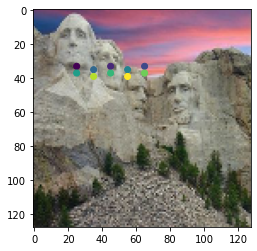

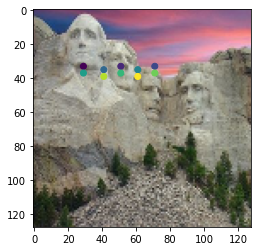

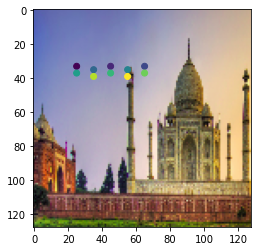

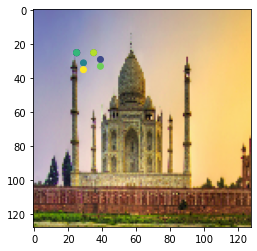

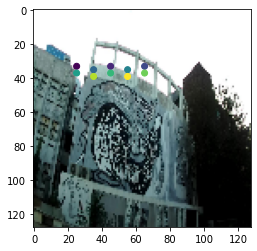

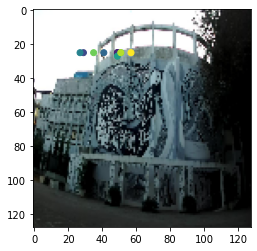

In [11]:
num_images = 3

for i in range(1,num_images+1):
    filenames = glob.glob('../images/Stereo Correspondence/'+str(i)+'*.jpg')
    if(len(filenames)==0):
         filenames = glob.glob('../images/Stereo Correspondence/'+str(i)+'*.png')
            
    filenames = sorted(filenames)
    images = []
    for file in filenames:
        images.append(plt.imread(file))

    mt_matched_x1_list,mt_matched_y1_list,mt_matched_x2_list,mt_matched_y2_list,timee= intensity_based_Corr(images[0], images[1],51,2)
    re_mt_im1 = cv2.resize(images[0],(128,128))
    re_mt_im2 = cv2.resize(images[1],(128,128))
    plot(re_mt_im1,mt_matched_x1_list, mt_matched_y1_list)
    plot(re_mt_im2,mt_matched_x2_list, mt_matched_y2_list)

2. Recall that for a point in one image, its corresponding point in the other image
is found along its epipolar line. Select few points in the first image and then plot
their corresponding epipolar lines on the second. Repeat the same for the second
image.

In [12]:
def drawEpipolar(img1,img2,lines,pts1,pts2):
    img1 = img1.copy()
    img2 = img2.copy()
    r,c,d = img1.shape
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        
        color = tuple(np.random.randint(0,255,3).tolist())
    
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
     
    return img1,img2, color

In [13]:
def plot4(img,pts,color):
    x_list = []
    y_list = []
    for pt in pts:
        (x,y) = pt
        x_list.append(x)
        y_list.append(y)
    plot2(img,x_list,y_list,"")
        
  
    

In [14]:
def calc_drawEpipolarLines(img1,img2):
    matches, kp1 , kp2 , des1 , des2 = match_keypoints(img1,img2)
    
    kp1_point_list = np.array([kp1[m[0].queryIdx].pt for m in matches])
    kp2_point_list = np.array([kp2[m[0].trainIdx].pt for m in matches])

    pts1 = np.array(kp1_point_list)
    pts2 = np.array(kp2_point_list)
    
   
    F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
    
    pts1 = pts1[mask.ravel()==1] 
    pts2 = pts2[mask.ravel()==1]
    
    pts1_homo,pts2_homo = convert_ToHomo(pts1,pts2) 
    
    lines1 = (F.T@(pts2_homo.T)).T 
    lines2 = (F@(pts1_homo.T)).T 

    img5,img6,color = drawEpipolar(img1,img2,lines1,pts1,pts2)
    plot4(img5,pts1,color)
    plot4(img6,pts2,color)
    
    img3,img4, color = drawEpipolar(img2,img1,lines2,pts2,pts1)
    plot4(img3,pts1,color)
    plot4(img4,pts2,color)
    
    return F, pts1, pts2

In [15]:
ptshimalaya = ((790.3555465021534, 113.57552754543792),
                     (820.3555465021534, 113.57552754543792),
                     (490.448187255766, 133.92905366080788),
                     (103.927111181845, 320.7025874253788),
                     (401.92745730581845, 360.7025874253788),
                     (201.92745730581845, 320.7025874253788),
                     (122.28098342118835, 533.8159785157225))

ptstaj = ((140.40725806451616, 65.38417338709678), (340.40725806451616, 165.38417338709678),(240.40725806451616, 65.38417338709678),(335.10483870967744, 31.472883064516168), (467.8266129032258, 148.99304435483873), (312.7096774193549, 68.8922379032258))
ptsmountain = ((40.20073332557328, 21.585438249330707),(240.20073332557328, 121.585438249330707),(140.20073332557328, 21.585438249330707),(50.10644860900942, 41.39686881620301), (151.74770108252827, 96.95501105808404),(202.13764404609478, 102.12321033639856))
pts_tocheck = [ptsmountain, ptstaj, ptshimalaya]

In [16]:
def pltPointstoCheck(img1,img2,pts):
    for pt in pts:
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = 0,np.round(pt[1]).astype(np.int)
        x1,y1 = img1.shape[1],np.round(pt[1]).astype(np.int)
        img2 = cv2.line(img2, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(np.round(pt).astype(np.int)),5,color,-1)
        img2 = cv2.circle(img2,tuple(np.round(pt).astype(np.int)),5,color,-1)
        
    return img1,img2

3. Rectify the pair of images and on these new images, find the correspondences using
greedy matching.

In [17]:
def greedyMatcher(img1,img2,pts):
    tic = time.time()

    img1 = cv2.normalize(img1, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    img2 = cv2.normalize(img2, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        
    ws = 51
    s = 1
    
    img1_vec_list = []
    y2_match_list = []
    matched_y2_list = []
    
    x1_match_list = [np.int(pt[0]) for pt in pts]
    matched_y1_list = [np.int(pt[1]) for pt in pts]
    x2_match = x1_match_list[0]
    matched_y2 = matched_y1_list[0]
    
    for i,j in zip(matched_y1_list,x1_match_list):
        img1_vec = (img1[i-25:i+25+1, j-25:j+25+1]).flatten()
        img1_vec_list.append(img1_vec)
    
    for x in range(len(pts)):        
            img1_vector = np.array(img1_vec_list[x])
            maxcorr_dis = -1
            h = img2.shape[1]-25
            for k in range(0,h,s):   
                    img2_vector = np.array((img2[matched_y1_list[x]-25:matched_y1_list[x]+25+1, k-25:k+25+1]).flatten())            
                    corrdis = corr(img1_vector,img2_vector)
                    
                    if corrdis  > maxcorr_dis:
                        maxcorr_dis = corrdis
                        x2_match = k
                        matched_y2 = matched_y1_list[x]
            
            y2_match_list.append(x2_match)
            matched_y2_list.append(matched_y2)
    tac= time.time()
    return x1_match_list,matched_y1_list,y2_match_list,matched_y2_list, tac-tic  

def plot2(img,x1,y1,title):
    plt.figure()
    plt.imshow(img)
    plt.scatter(x1, y1) 
    plt.title(title) 
    
def plot3(img,x1,y1,title):
    plt.figure()
    plt.imshow(img)
    plt.scatter(x1[100:200:20], y1[100:200:20]) 
    plt.title(title) 

4) Compare the Brute force and Greedy based solution for the stereo correspondence
problem.

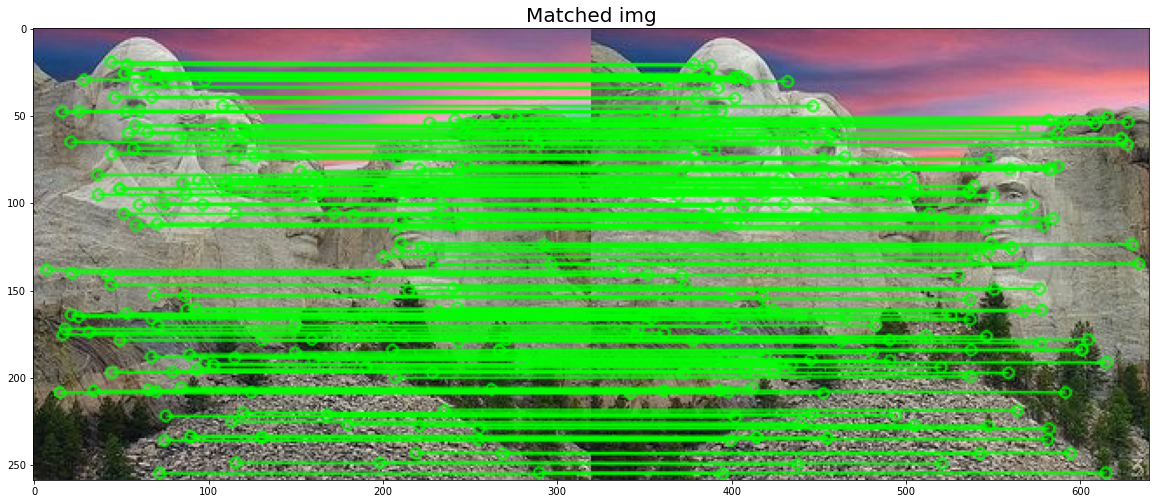

time by Greedy 0.02501988410949707
time by brute force -753.8185226917267


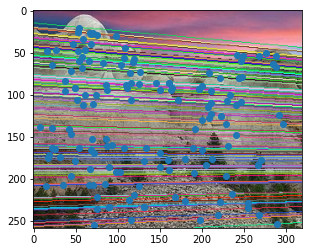

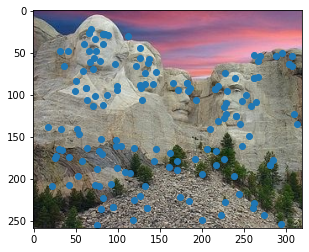

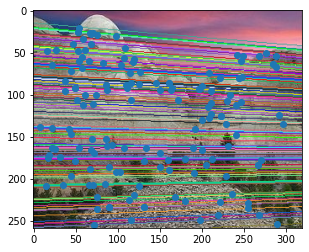

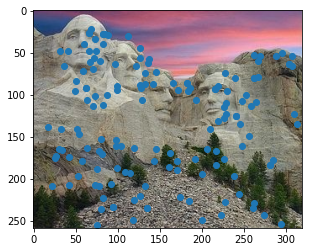

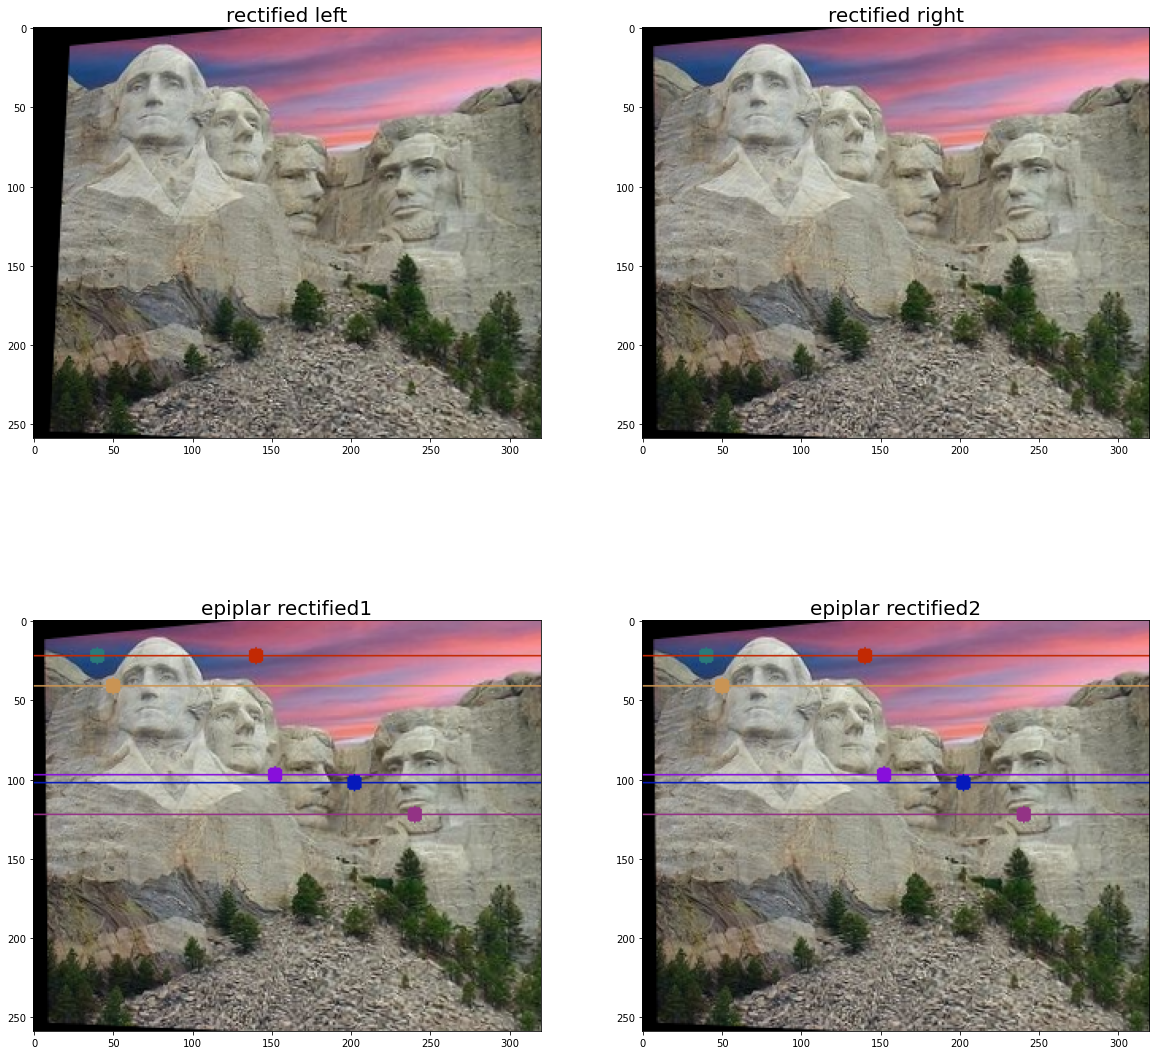

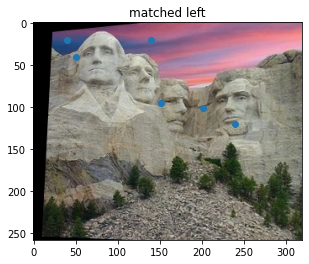

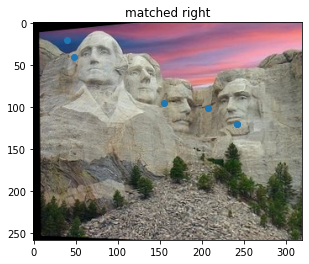

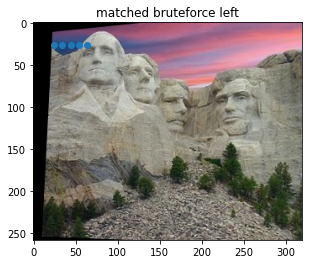

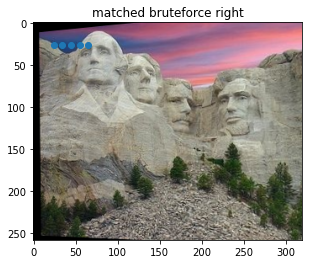

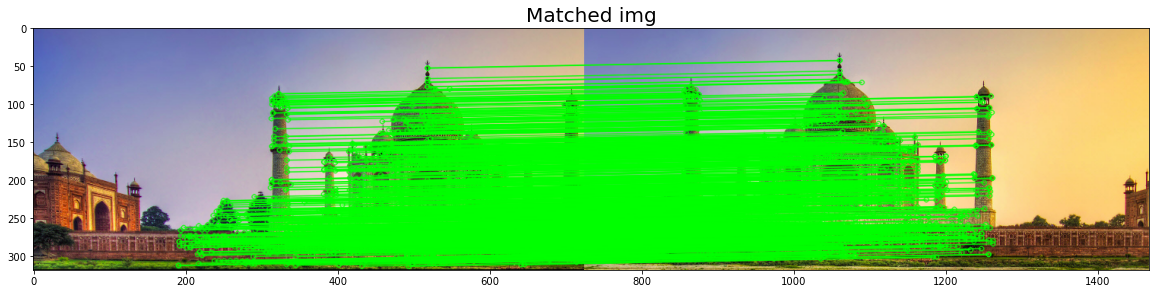

time by Greedy 0.08088421821594238
time by brute force 123.0008156299591


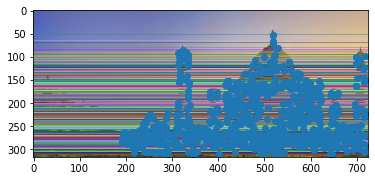

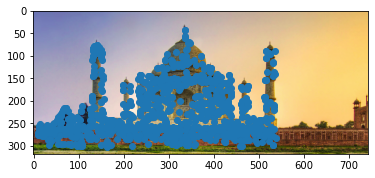

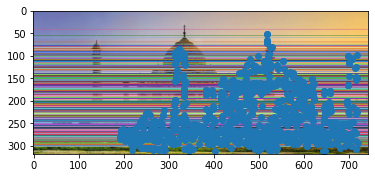

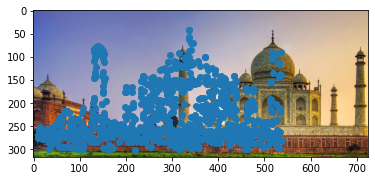

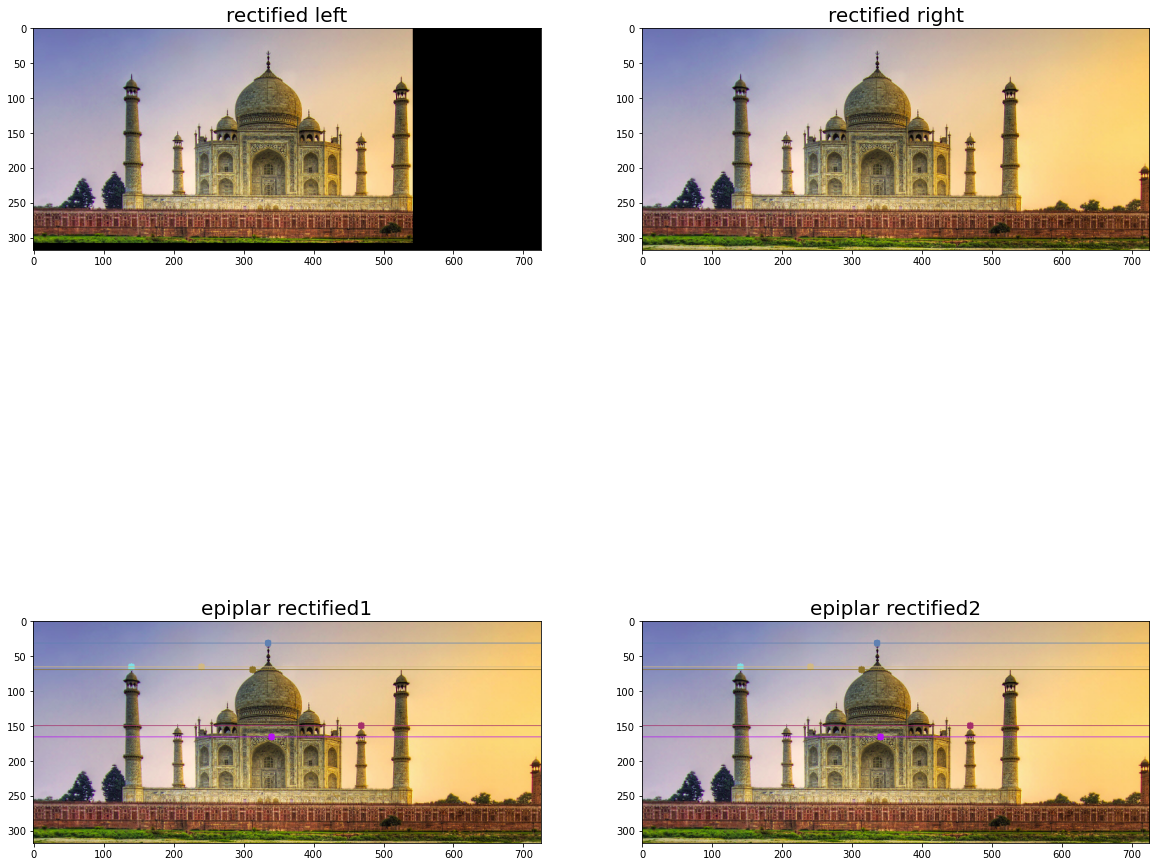

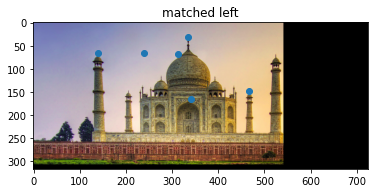

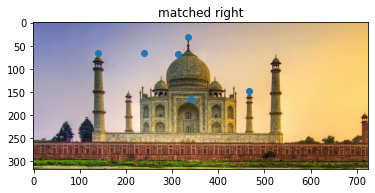

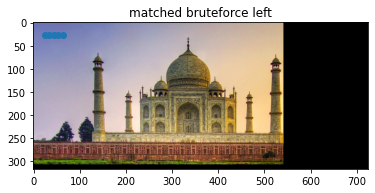

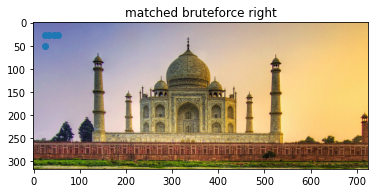

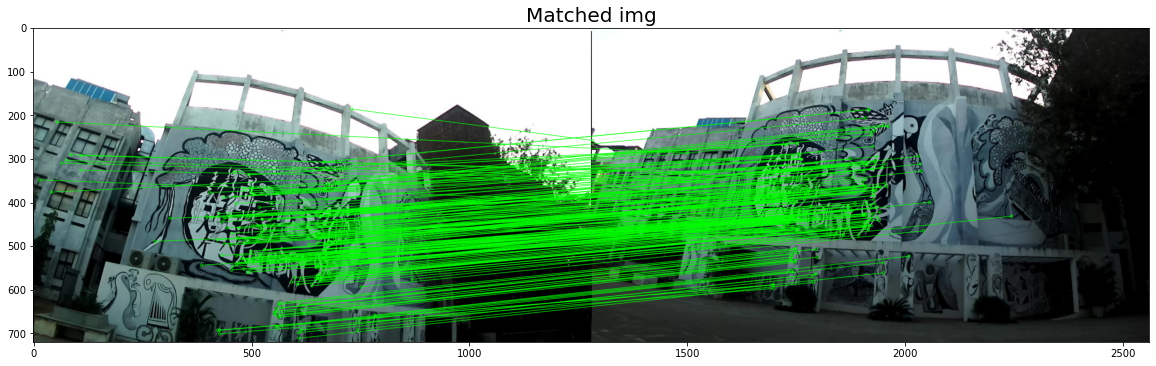

time by Greedy 0.17073869705200195
time by brute force 125.70184373855591


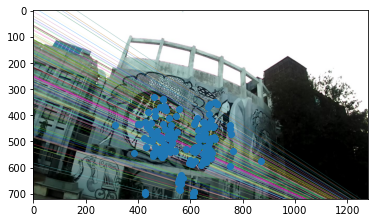

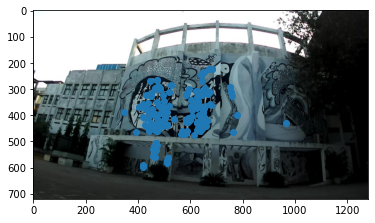

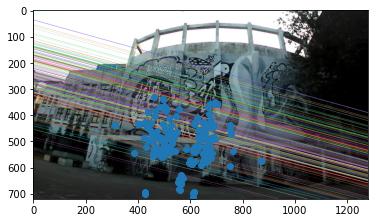

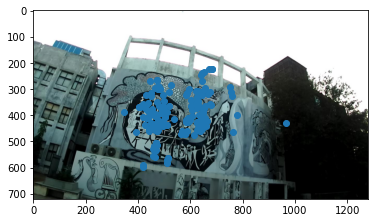

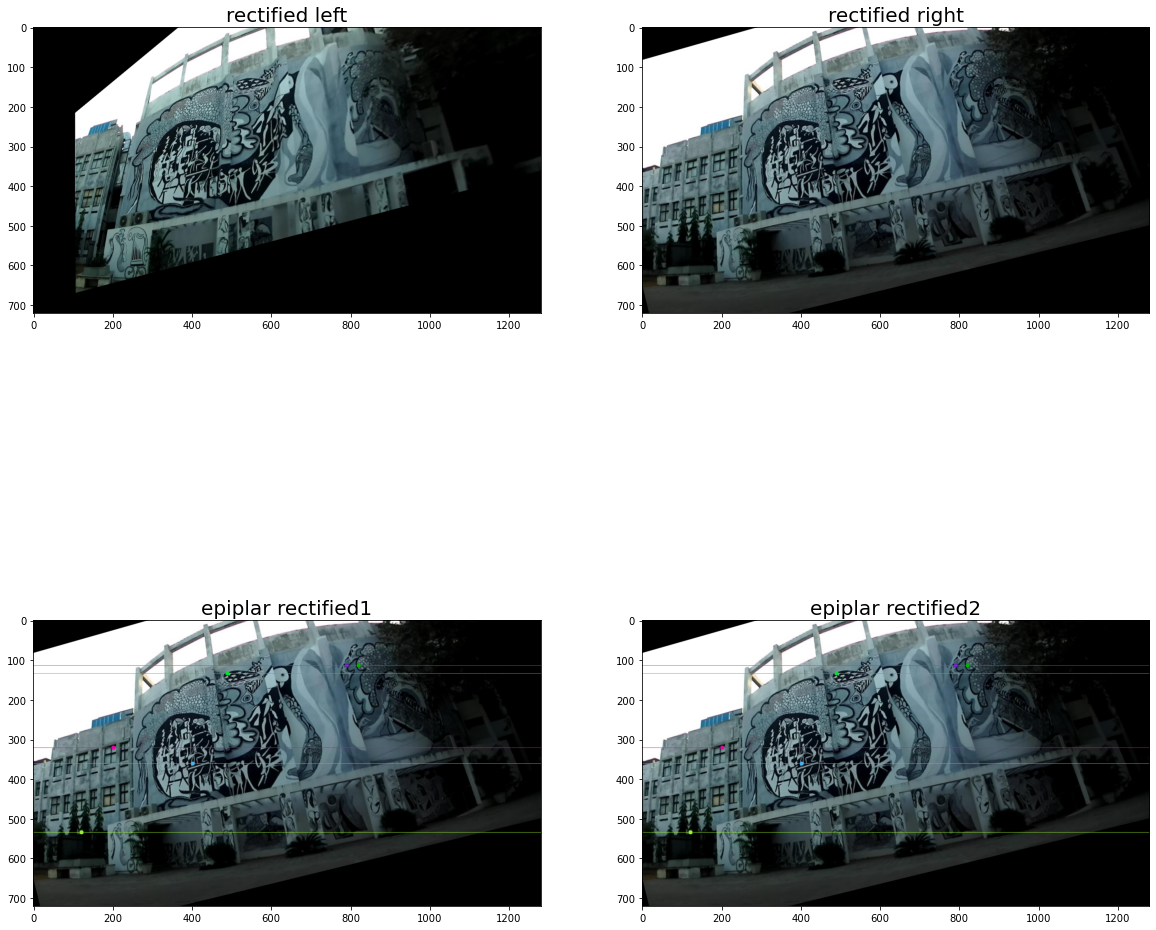

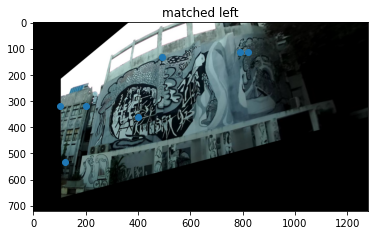

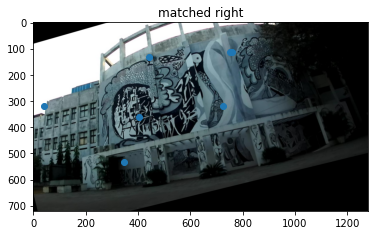

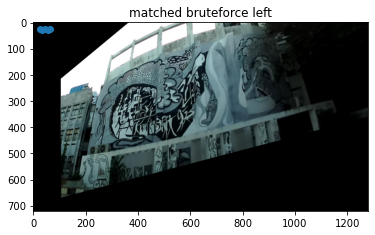

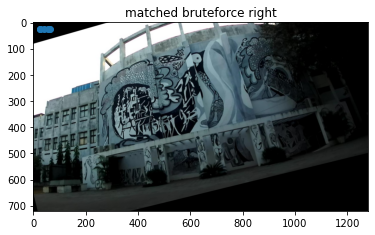

In [18]:
num_images = 3
for i in range(1,num_images+1):
    filenames = glob.glob('../images/Stereo Correspondence/'+str(i)+'*.jpg')
    if(len(filenames)==0):
         filenames = glob.glob('../images/Stereo Correspondence/'+str(i)+'*.png') 
    filenames = sorted(filenames)
    images = []
    for file in filenames:
        images.append(cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB))
    
    F,pts1,pts2 = calc_drawEpipolarLines(images[0],images[1])
 
    h = images[0].shape[0]
    w = images[0].shape[1]
    
    success, h1,h2 =cv2.stereoRectifyUncalibrated(pts1, pts2, F, (h,w))
    corrected1=cv2.warpPerspective(images[0], h1, (w,h))
    corrected2=cv2.warpPerspective(images[1], h2, (w,h))
    rectified_img_withpts,rectified_img_withpts = pltPointstoCheck(corrected1.copy(),corrected2.copy(),pts_tocheck[i-1])
    
    # Greedy matcher
    matched_x1_list,matched_y1_list,matched_x2_list,matched_y2_list,timee = greedyMatcher(corrected1.copy(),corrected2.copy(),pts_tocheck[i-1])
    print("time by Greedy",timee)
    
    # Brute-force matcher
    matched_x1_list_brute,matched_y1_list_brute,matched_x2_list_brute,matched_y2_list_brute,timee = intensity_based_Corr(corrected1.copy(),corrected2.copy(),50,1)
    print("time by brute force",timee)  
    display_img_arr([corrected1,corrected2,rectified_img_withpts,rectified_img_withpts], 2, 2, (20, 20), ['rectified left','rectified right','epiplar rectified1','epiplar rectified2'])
    
    plot2(corrected1.copy(),matched_x1_list,matched_y1_list,'matched left')
    plot2(corrected2.copy(),matched_x2_list,matched_y2_list,'matched right')
    
    plot3(corrected1,matched_x1_list_brute,matched_y1_list_brute,'matched bruteforce left')
    plot3(corrected2,matched_x2_list_brute,matched_y2_list_brute,'matched bruteforce right')
    
   
    


As we can see, Greedy takes in more time, than Brute-force

## Bonus: Dense SIFT

Note: Dense SIFT is SIFT with all sizes of windows

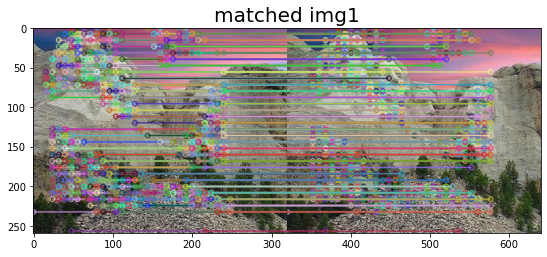

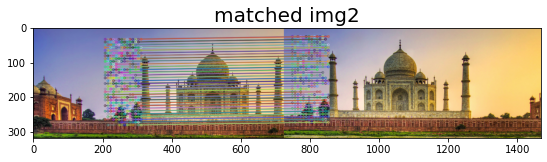

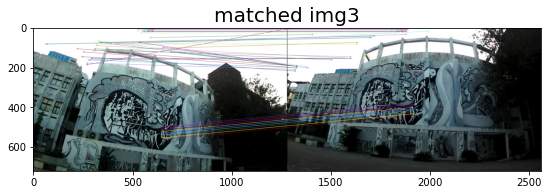

In [19]:
 def compute_key_points(img):
        h = img.shape[0]
        w = img.shape[1]
        step = 8
        radius = 8
        key_points = []
        for i in range(0, h, step):
            for j in range(0, w, step):
                key_points.append(cv2.KeyPoint(i, j, radius))
        return key_points
    
def compute_features(img,key_points):
    sift = cv2.SIFT_create()
    features = sift.compute(img, key_points)
    return features

def denseSIFT(image1,image2):
    img1_gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    
    key_points1 = compute_key_points(image1)
    key_points_left, desc_left = compute_features(image1,key_points1)
    
    key_points2 = compute_key_points(image2)
    key_points_right, desc_right = compute_features(image2,key_points2)
    
    bf = cv2.BFMatcher()
    distance=0.5
    matches = bf.knnMatch(desc_left, desc_right, k=2)
    
    good = []
    for m, n in matches:
        if m.distance < distance * n.distance:
            good.append([m])
    
    return cv2.drawMatchesKnn(image1,key_points_left,image2,key_points_right,good,None,flags=2)
 

num_images = 3
for i in range(1,num_images+1):
    filenames = glob.glob('../images/Stereo Correspondence/'+str(i)+'*.jpg')
    if(len(filenames)==0):
         filenames = glob.glob('../images/Stereo Correspondence/'+str(i)+'*.png') 
    filenames = sorted(filenames)
    images = []
    for file in filenames:
        images.append(cv2.cvtColor(cv2.imread(file),cv2.COLOR_BGR2RGB))
    image_output = denseSIFT(images[0], images[1])
   
    display_img_arr([image_output], 1, 2, (20, 20), ['matched img'+str(i)])
    
